In [1]:
import openai
openai.api_key = 'your key'  
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.0,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



In [2]:
sys_prompt = """
We have a manipulator and we want you to help plan how it should move to perform tasks using the
following APIs:
    def end_effector_to(position_obj)
position_obj is a list of 3 float numbers [x,y,z]
    def end_effector_open()
Open the end effector
    def get_object_center_position(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    def get_object_size(obj_name)
Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    def get_current_position()
Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    def normalize_table_position(position_obj)
Given a position, return a normalized position that is on the table.
    def denormalize_table_position(position_obj)
Given a normalized position, return a position that is on the table.
    def check_empty(position_obj)
Return True if the position is empty, False otherwise.

Example answer code:
    import numpy as np
    # You can see 'harry potter', 'hobbitt', 'the lord of the rings', 'the witcher', 'the chronicles of narnia' on the shelf_row1
    # You can see 'modern robotics', 'artificial intelligence', 'convex optimization', 'physics' on the shelf_row2
    # You can see 'peter pan', 'alice in wonderland', 'the little prince', 'the wizard of oz' on the shelf_row3
    # place the book named 'harry_potter_2' in the shelf_row1
    def place_object_shelf_row1():
        object_pos = get_object_center_position('shelf_row1')
        object_size = get_object_size('shelf_row1')
        range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
        for y in np.linspace(range_y[0], range_y[1], 10):
            target_pos = [object_pos[0], y, object_pos[2]]
            empty = check_empty(target_pos)
            if empty:
                end_effector_to(target_pos)
                end_effector_open()
                return
    place_object_shelf_row1()

    # You can see 'harry potter', 'hobbitt', 'the lord of the rings', 'the witcher', 'the chronicles of narnia' on the shelf_row1
    # You can see 'modern robotics', 'artificial intelligence', 'convex optimization', 'physics' on the shelf_row2
    # You can see 'peter pan', 'alice in wonderland', 'the little prince', 'the wizard of oz' on the shelf_row3
    # place the book named 'statistics' in the shelf_row2
    def place_object_shelf_row1():
        object_pos = get_object_center_position('shelf_row2')
        object_size = get_object_size('shelf_row1')
        range_y = [object_pos[1] - object_size[1] + 0.05 , object_pos[1] + object_size[1]-0.05]
        for y in np.linspace(range_y[0], range_y[1], 10):
            target_pos = [object_pos[0], y, object_pos[2]]
            empty = check_empty(target_pos)
            if empty:
                end_effector_to(target_pos)
                end_effector_open()
                return
    place_object_shelf_row2()

Remember:
1. Always format the code in code blocks.
2. Do not invent new functions or classes. The only allowed functions you can call are the ones listed
above. Do not leave unimplemented code blocks in your response.
3. The only allowed library is numpy. Do not import or use any other library.
4. If you are not sure what value to use, just use your best judge. Do not use None for anything.
5. You do not need to make the robot do extra things not mentioned in the plan such as stopping the
robot.
6. Try your best to generate code despite the lack of context.
7. Only use end_effector_to, end_effector_open once in your code.
"""
llm = ChatGPT(sys_prompt, model_engine=model_name)
llm.reset()


In [3]:
import mujoco#,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [4]:
xml_path = '../../../asset/visualize_figure_bookshelf_genre.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([-1.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-5,0.80,0])

shelf_pos = np.array([0.8,0.0,0.75])
shelf_2nd_pos = shelf_pos + np.array([0.,0.,0.25])
env.model.body('shelf_row1').pos = shelf_pos
env.model.body('shelf_row1').quat = r2quat(rpy2r(np.radians([0, 0, 90])))

obj_box_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("obj_box"))]
obj_wine_names = [body_name for body_name in env.body_names
                if body_name is not None and (body_name.startswith("obj_wine"))]
obj_book_names = [body_name for body_name in env.body_names
            if body_name is not None and (body_name.startswith("book"))]

# Place objects
n_wine_obj = 2
# env.place_objects_random(n_obj=n_wine_obj, obj_names=obj_wine_names, x_range=[0.80, 0.85], y_range=[-0.2, 0.2], z_range=[1.35,1.36], min_dist=0.05, COLORS=False, VERBOSE=True)
env.model.joint(env.model.body('obj_wine_01').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0.02, -0.10, 0.5])
env.model.joint(env.model.body('obj_wine_02').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([-0.05, -0.18, 0.5])

# Book1 is target_object
env.model.joint(env.model.body('book2').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0, 0.225, 0.02])
env.model.joint(env.model.body('book3').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0, 0.16, 0.02])
env.model.joint(env.model.body('book4').jntadr[0]).qpos0[:3] = shelf_2nd_pos + np.array([0, 0.11, 0.02])
env.model.joint(env.model.body('book6').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.22, 0.02])
env.model.joint(env.model.body('book7').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.16, 0.02])
env.model.joint(env.model.body('book8').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.12, 0.02])
env.model.joint(env.model.body('book9').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0, -0.07, 0.02])

env.model.joint(env.model.body('book1').jntadr[0]).qpos0[:3] = np.array([0.2, -0.4, 0.8])
env.model.joint(env.model.body('book1').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.array([1.57, 0, 0])))


window


In [5]:
shelf_poses = {
    'shelf_row1': np.array([0.8,0.0,0.78]),
    'shelf_row2': np.array([0.8,0.0,1.03]),
    'shelf_row3': np.array([0.8,0.0,1.28]),
}

In [6]:
object_info_dict = dict()
book_shelf_size = [0.243, 0.11, 0.005]
book_size = [0.03, 0.07, 0.11]
glass_size = [0.03, 0.03, 0.07]
table_size   = env.model.geom_aabb[env.model.body('avoiding_object_table').geomadr][0][3:]

object_info_dict['avoiding_object_table'] = {'name':"table", 'size': table_size, 'position': [0.38+0.45, 0., 0.8], 'rotation':[0., 0., 0.]}


In [7]:
import math
def quat2r(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
        return roll_x, pitch_y, yaw_z

In [8]:
seen_obj_names = []
graphs = {}
THRES = [0.7, 1.0, 1.3]
env.step()
for body_name in env.body_names:
    # if 'wine' in body_name:
    #     pos = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[:3]
    #     rot = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[3:]
    #     z_ = pos[2]
    #     if z_ < THRES[1]:
    #         graphs[body_name] = 'shelf_row1'
    #     elif z_ < THRES[2]:
    #         graphs[body_name] = 'shelf_row2'
    #     else: 
    #         graphs[body_name] = 'shelf_row3'
    #     seen_obj_names.append(body_name)
    #     object_info_dict[body_name] = {'name':"glass", 'size': glass_size, 'position': pos, 'rotation': quat2r(*rot)}
    if 'book' in body_name:
        pos = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[:3]
        rot = env.model.joint(env.model.body(body_name).jntadr[0]).qpos0[3:]
        # print(pos, body_name)
        z_ = pos[2]
        seen_obj_names.append(body_name)
        if body_name == 'book1': continue
        object_info_dict[body_name] = {'name':"book", 'size': book_size, 'position':pos, 'rotation':quat2r(*rot)}
        if z_ < THRES[1]:
            graphs[body_name] = 'shelf_row1'
        elif z_ < THRES[2]:
            graphs[body_name] = 'shelf_row2'
        else: 
            graphs[body_name] = 'shelf_row3'
    elif 'shelf_row' in body_name:
        pos = shelf_poses[body_name]
        rot = env.model.body(body_name).quat 
        seen_obj_names.append(body_name)
        print(pos, body_name)
        object_info_dict[body_name] = {'name':"bookshelf", 'size': book_shelf_size, 'position': pos, 'rotation':quat2r(*rot)}

[0.8  0.   0.78] shelf_row1
[0.8  0.   1.03] shelf_row2
[0.8  0.   1.28] shelf_row3


In [9]:
object_info_dict

{'avoiding_object_table': {'name': 'table',
  'size': array([0.45, 0.6 , 0.37]),
  'position': [0.8300000000000001, 0.0, 0.8],
  'rotation': [0.0, 0.0, 0.0]},
 'book2': {'name': 'book',
  'size': [0.03, 0.07, 0.11],
  'position': array([0.8 , 0.23, 1.02]),
  'rotation': (3.141592653589793, 0.0, 0.0)},
 'book3': {'name': 'book',
  'size': [0.03, 0.07, 0.11],
  'position': array([0.8 , 0.16, 1.02]),
  'rotation': (3.141592653589793, 0.0, 0.0)},
 'book4': {'name': 'book',
  'size': [0.03, 0.07, 0.11],
  'position': array([0.8 , 0.11, 1.02]),
  'rotation': (3.141592653589793, 0.0, 0.0)},
 'book5': {'name': 'book',
  'size': [0.03, 0.07, 0.11],
  'position': array([0., 0., 0.]),
  'rotation': (3.141592653589793, 0.0, 0.0)},
 'book6': {'name': 'book',
  'size': [0.03, 0.07, 0.11],
  'position': array([ 0.8 , -0.22,  0.77]),
  'rotation': (3.141592653589793, 0.0, 0.0)},
 'book7': {'name': 'book',
  'size': [0.03, 0.07, 0.11],
  'position': array([ 0.8 , -0.16,  0.77]),
  'rotation': (3.141592

In [10]:
import math
def quat2r(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
        return roll_x, pitch_y, yaw_z

## LLM

In [11]:
llm.reset()
target_object_name = ['Calculus','Enginnering Mathmatics', 'Dynamics','Chemistry', 'Biology']

prompt = "# You can see 'harry potter', 'hobbitt', 'the lord of the rings', 'the witcher', 'the chronicles of narnia' on the shelf_row1\n"
prompt += "# You can see 'modern robotics', 'artificial intelligence', 'convex optimization', 'physics' on the shelf_row2\n"
prompt += "# Place the book named {} on the shelf that it belongs to\n".format(target_object_name[0])
code = llm.get_answer(prompt=prompt)

In [12]:
print(code)

def place_object_calculus():
    # Get the position and size of the shelf_row2
    shelf_row2_pos = get_object_center_position('shelf_row2')
    shelf_row2_size = get_object_size('shelf_row2')
    
    # Calculate the range of y values within the shelf_row2
    range_y = [shelf_row2_pos[1] - shelf_row2_size[1] + 0.05, shelf_row2_pos[1] + shelf_row2_size[1] - 0.05]
    
    # Iterate through the range of y values
    for y in np.linspace(range_y[0], range_y[1], 10):
        # Create the target position
        target_pos = [shelf_row2_pos[0], y, shelf_row2_pos[2]]
        
        # Check if the target position is empty
        empty = check_empty(target_pos)
        
        # If the target position is empty, move the end effector to the target position and open it
        if empty:
            end_effector_to(target_pos)
            end_effector_open()
            return

# Call the function to place the object 'Calculus' on the shelf_row2
place_object_calculus()


In [13]:
'''
define functions
'''
def end_effector_to(position_obj):
    target_obj_name = 'book1'
    target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
    target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = position_obj
    # TODO check rotation here
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 0, 0])))
    print("Move the end effector to {}".format(position_obj))
    #position_obj is a list of 3 float numbers [x,y,z]

def end_effector_open():
    #Open the end effector
    pass
def get_object_center_position(obj_name):
    #Given an object name, return a list of 3 float numbers [x,y,z] for the object position.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            return object_info_dict[obj]['position']
    
    print("Object {} not found".format(obj_name))
    current_pos = get_current_position()
    return current_pos
    
def get_object_size(obj_name):
    # Given an object name, return a list of 3 float numbers [x,y,z] for the object size.
    for obj in object_info_dict:
        if object_info_dict[obj]['name'] == obj_name or obj == obj_name:
            # print("Object {} found".format(obj_name))
            return object_info_dict[obj]['size']
    return [0.0,0.0,0.0]  
def get_current_position():
    # Return a list of 3 float numbers [x,y,z] for the current position of the end effector.
    p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
    return p_tcp

def normalize_table_position(position_obj):
    #Given a position, return a normalized position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    normalized_pos = (position_obj - table_pos) / (table_size)
    return normalized_pos
def denormalize_table_position(position_obj):
    #Given a normalized position (0-1), return a position that is on the table.
    table_size = object_info_dict['avoiding_object_table']['size']#env.model.geom_aabb[env.model.body('base_table').geomadr][0][3:]
    table_pos =object_info_dict['avoiding_object_table']['position'] #env.model.body('base_table').pos
    denormalized_pos = position_obj * (table_size)+ table_pos
    denormalized_pos[2] = 0.9
    return denormalized_pos

def check_empty(position_obj):
    # Return True if the position is empty, False otherwise.
    for obj in object_info_dict:
        if 'shelf_row' in obj: continue
        obj_pos = object_info_dict[obj]['position']
        obj_pos = np.array(obj_pos)
        position_obj = np.array(position_obj)
        if np.linalg.norm(obj_pos - position_obj) < 0.05:
            return False
    return True

In [14]:
# code_in = "seen_objects = "+str(seen_obj_names)+"\n"
code_in = code

## Excecute

Move the end effector to [0.8, -0.06, 1.03]
[-0.86 -0.01  1.16]


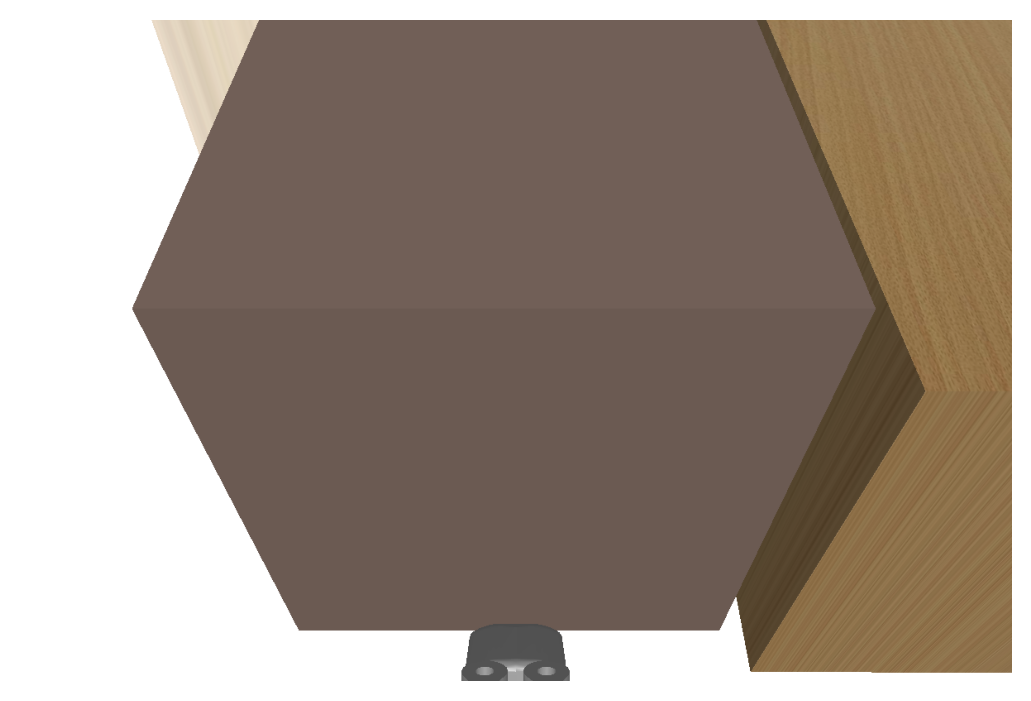

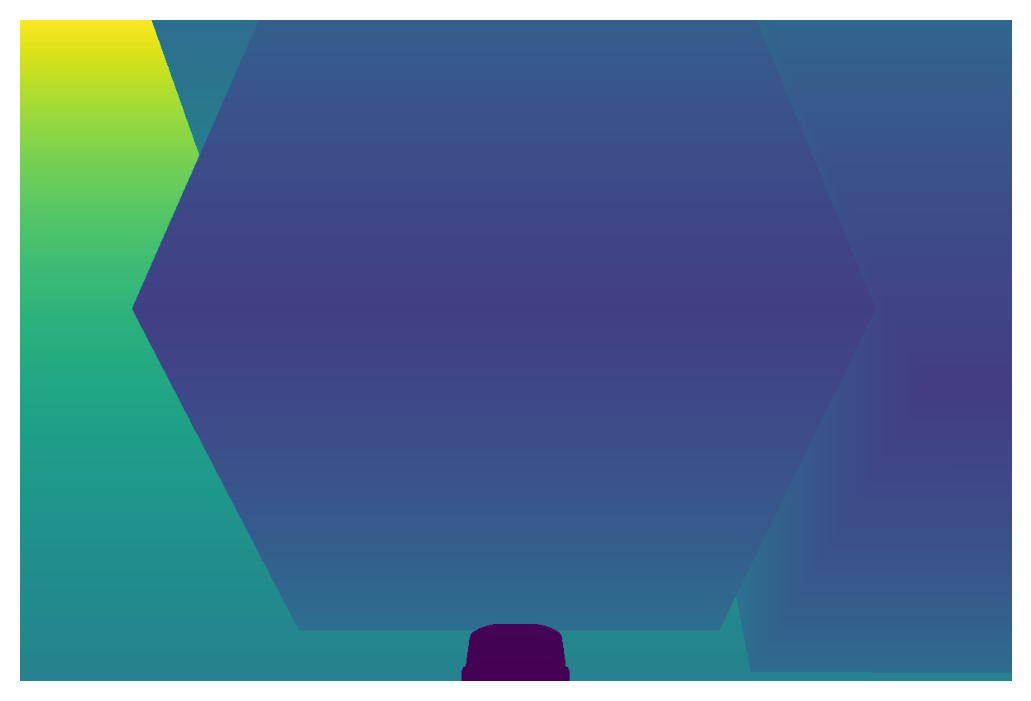

Done. Tick:[39277] Time:[78.55]sec


In [15]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0
env.reset()
exec(code_in)
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))

tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))